In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image

from scipy.linalg import sqrtm
from torchvision.models import inception_v3


In [2]:
def get_all_vangogh_images(root_dir):
    """Recursively get all image files from Van Gogh directory structure"""
    image_files = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))
    return image_files

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, is_celeba=True):
        self.transform = transform
        self.is_celeba = is_celeba
        self.root = root
        
        if is_celeba:
            # CelebA has a flat directory structure
            self.files = [f for f in os.listdir(root) if f.endswith(('.jpg', '.png', '.jpeg'))]
        else:
            # Van Gogh dataset may have nested directories
            self.files = get_all_vangogh_images(root)
            
    def __getitem__(self, index):
        img_path = self.files[index]
        if self.is_celeba:
            img_path = os.path.join(self.root, img_path)
                
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
                
        return img
            
    def __len__(self):
        return len(self.files)


In [3]:
# Define paths
celeba_root = './data/celeba/img_align_celeba'
vangogh_root = './data/vangogh/Van Gogh Paintings/VincentVanGogh'

# Create the images directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Define resolutions for progressive growing
resolutions = [4, 8, 16, 32, 64, 128, 256]

# Placeholder for data loaders at different resolutions
dataloaders_A = {}
dataloaders_B = {}

# Mac-optimized settings
batch_size = 8  # Adjust based on your GPU memory
num_workers = 0  # Set to 0 for compatibility on some systems

# Create dataloaders for each resolution
for res in resolutions:
    transform = transforms.Compose([
        transforms.Resize((res, res)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # Initialize datasets with correct paths
    dataset_A = ImageDataset(
        root=celeba_root,
        transform=transform,
        is_celeba=True
    )

    dataset_B = ImageDataset(
        root=vangogh_root,
        transform=transform,
        is_celeba=False
    )

    # Create dataloaders with Mac-optimized settings
    dataloaders_A[res] = DataLoader(
        dataset_A,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )

    dataloaders_B[res] = DataLoader(
        dataset_B,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )

# Verify datasets loaded correctly
print(f"CelebA dataset size: {len(dataset_A)}")
print(f"Van Gogh dataset size: {len(dataset_B)}")


CelebA dataset size: 202599
Van Gogh dataset size: 2025


In [4]:
class WeightedSumLayer(nn.Module):
    def __init__(self, alpha):
        super(WeightedSumLayer, self).__init__()
        self.alpha = alpha

    def forward(self, x_new, x_old):
        return self.alpha * x_new + (1 - self.alpha) * x_old

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def deconv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),  # Upsampling
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


In [5]:
class ProgressiveGenerator(nn.Module):
    def __init__(self, num_blocks):
        super(ProgressiveGenerator, self).__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        self.to_rgb = nn.ModuleList()
        self.alpha = 1.0  # Start with 1.0 for the initial resolution

        # Initial block
        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 512, 3, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.to_rgb.append(nn.Conv2d(512, 3, 1))

        # Additional blocks: adding more conv layers for higher resolutions
        in_channels = 512
        for _ in range(num_blocks - 1):
            out_channels = max(in_channels // 2, 64)
            self.blocks.append(conv_block(in_channels, out_channels))
            self.to_rgb.append(nn.Conv2d(out_channels, 3, 1))
            in_channels = out_channels

    def forward(self, x, step):
        x = self.initial_block(x)
        for i in range(step):
            x = self.blocks[i](x)
        out = torch.tanh(self.to_rgb[step](x))
        return out


In [6]:
class ProgressiveDiscriminator(nn.Module):
    def __init__(self, num_blocks):
        super(ProgressiveDiscriminator, self).__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        self.from_rgb = nn.ModuleList()
        self.alpha = 1.0

        in_channels = 512  # Match Generator's initial output channels
        for _ in range(num_blocks - 1):
            out_channels = min(in_channels * 2, 512)
            self.blocks.append(conv_block(in_channels, out_channels))
            self.from_rgb.append(nn.Conv2d(3, in_channels, 1))
            in_channels = out_channels

        # Final block with AdaptiveAvgPool2d to handle varying resolutions
        self.from_rgb.append(nn.Conv2d(3, in_channels, 1))
        self.final_block = nn.Sequential(
            nn.Conv2d(in_channels, 512, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),  # Ensure output is (batch_size, 512, 1, 1)
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x, step):
        x = self.from_rgb[step](x)
        for i in range(step, 0, -1):
            x = self.blocks[i - 1](x)
            # No downsampling to maintain same resolution

        x = self.final_block(x)
        return x


In [7]:
# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Initialize models
num_blocks = len(resolutions) - 1
G_AB = ProgressiveGenerator(num_blocks).to(device)
G_BA = ProgressiveGenerator(num_blocks).to(device)
D_A = ProgressiveDiscriminator(num_blocks).to(device)
D_B = ProgressiveDiscriminator(num_blocks).to(device)

# Optimizers
lr = 0.0002
optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))


Device: mps


In [8]:
# Function to save models and optimizers
def save_checkpoint(step, epoch, models, optimizers, save_dir='checkpoints'):
    # Create checkpoint directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    checkpoint = {
        'step': step,
        'epoch': epoch,
        'G_AB_state_dict': models['G_AB'].state_dict(),
        'G_BA_state_dict': models['G_BA'].state_dict(),
        'D_A_state_dict': models['D_A'].state_dict(),
        'D_B_state_dict': models['D_B'].state_dict(),
        'optimizer_G_state_dict': optimizers['G'].state_dict(),
        'optimizer_D_A_state_dict': optimizers['D_A'].state_dict(),
        'optimizer_D_B_state_dict': optimizers['D_B'].state_dict(),
    }
    
    path = os.path.join(save_dir, f'checkpoint_res{resolutions[step]}_epoch{epoch}.pth')
    torch.save(checkpoint, path)
    print(f'Checkpoint saved: {path}')


In [9]:
# # to save the mdoels
# models = {
#     'G_AB': G_AB,
#     'G_BA': G_BA,
#     'D_A': D_A,
#     'D_B': D_B
# }

# optimizers = {
#     'G': optimizer_G,
#     'D_A': optimizer_D_A,
#     'D_B': optimizer_D_B
# }


# num_epochs = 5  # Number of epochs per resolution
# total_steps = len(resolutions)

# for step, res in enumerate(resolutions):
#     print(f'\nTraining at resolution: {res}x{res}')

#     dataloader_A = dataloaders_A[res]
#     dataloader_B = dataloaders_B[res]

#     for epoch in range(num_epochs):
#         print(f'\nEpoch [{epoch+1}/{num_epochs}]')
#         for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
#             real_A = real_A.to(device)
#             real_B = real_B.to(device)

#             ###### Generators A2B and B2A ######
#             optimizer_G.zero_grad()

#             # Identity loss
#             same_B = G_AB(real_B, step)
#             loss_identity_B = criterion_identity(same_B, real_B) * 5.0

#             same_A = G_BA(real_A, step)
#             loss_identity_A = criterion_identity(same_A, real_A) * 5.0

#             # GAN loss
#             fake_B = G_AB(real_A, step)
#             pred_fake = D_B(fake_B, step)
#             valid = torch.ones_like(pred_fake).to(device)
#             loss_GAN_AB = criterion_GAN(pred_fake, valid)

#             fake_A = G_BA(real_B, step)
#             pred_fake = D_A(fake_A, step)
#             loss_GAN_BA = criterion_GAN(pred_fake, valid)

#             # Cycle loss
#             recovered_A = G_BA(fake_B, step)
#             loss_cycle_A = criterion_cycle(recovered_A, real_A) * 10.0

#             recovered_B = G_AB(fake_A, step)
#             loss_cycle_B = criterion_cycle(recovered_B, real_B) * 10.0

#             # Total loss
#             loss_G = loss_identity_A + loss_identity_B + loss_GAN_AB + loss_GAN_BA + loss_cycle_A + loss_cycle_B
#             loss_G.backward()
#             optimizer_G.step()

#             ###### Discriminator A ######
#             optimizer_D_A.zero_grad()

#             # Real loss
#             pred_real = D_A(real_A, step)
#             valid = torch.ones_like(pred_real).to(device)
#             loss_D_real = criterion_GAN(pred_real, valid)

#             # Fake loss
#             pred_fake = D_A(fake_A.detach(), step)
#             fake = torch.zeros_like(pred_fake).to(device)
#             loss_D_fake = criterion_GAN(pred_fake, fake)

#             # Total loss
#             loss_D_A = (loss_D_real + loss_D_fake) * 0.5
#             loss_D_A.backward()
#             optimizer_D_A.step()

#             ###### Discriminator B ######
#             optimizer_D_B.zero_grad()

#             # Real loss
#             pred_real = D_B(real_B, step)
#             valid = torch.ones_like(pred_real).to(device)
#             loss_D_real = criterion_GAN(pred_real, valid)

#             # Fake loss
#             pred_fake = D_B(fake_B.detach(), step)
#             fake = torch.zeros_like(pred_fake).to(device)
#             loss_D_fake = criterion_GAN(pred_fake, fake)

#             # Total loss
#             loss_D_B = (loss_D_real + loss_D_fake) * 0.5
#             loss_D_B.backward()
#             optimizer_D_B.step()

#             if i % 100 == 0:
#                 print(f'Batch [{i}/{min(len(dataloader_A), len(dataloader_B))}] '
#                       f'Loss_G: {loss_G.item():.4f} '
#                       f'Loss_D_A: {loss_D_A.item():.4f} '
#                       f'Loss_D_B: {loss_D_B.item():.4f}')

#         # Save sample images
#         if (epoch + 1) % 1 == 0:
#             with torch.no_grad():
#                 fake_B = G_AB(real_A, step)
#                 fake_A = G_BA(real_B, step)
#                 save_image(fake_B * 0.5 + 0.5, f'images/fake_B_res{res}_epoch{epoch+1}.png')
#                 save_image(fake_A * 0.5 + 0.5, f'images/fake_A_res{res}_epoch{epoch+1}.png')
                
#     # Save checkpoint at the end of each resolution
#     save_checkpoint(
#         step=step,
#         epoch=num_epochs,
#         models=models,
#         optimizers=optimizers,
#         save_dir=f'checkpoints/resolution_{res}'
#     )
#     print(f'\nCompleted training for resolution {res}x{res}')


In [10]:
def calculate_fid(real_images, fake_images):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = nn.Identity()
    model.eval()

    real_features = []
    fake_features = []

    with torch.no_grad():
        for img in real_images:
            img = img.unsqueeze(0).to(device)
            feat = model(img)
            real_features.append(feat.cpu().numpy())

        for img in fake_images:
            img = img.unsqueeze(0).to(device)
            feat = model(img)
            fake_features.append(feat.cpu().numpy())

    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [11]:
def calculate_inception_score(images, splits=10):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = nn.Softmax(dim=1)
    model.eval()

    preds = []
    with torch.no_grad():
        for img in images:
            img = nn.functional.interpolate(img.unsqueeze(0), size=(299, 299), mode='bilinear', align_corners=False)
            img = img.to(device)
            pred = model(img)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    scores = []

    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean(np.sum(part * (np.log(part + 1e-6) - np.log(py + 1e-6)), axis=1))))

    return np.mean(scores), np.std(scores)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score for 128x128: 677.2033154884075
Inception Score for 128x128: 1.0413328409194946 ± 0.00801411084830761


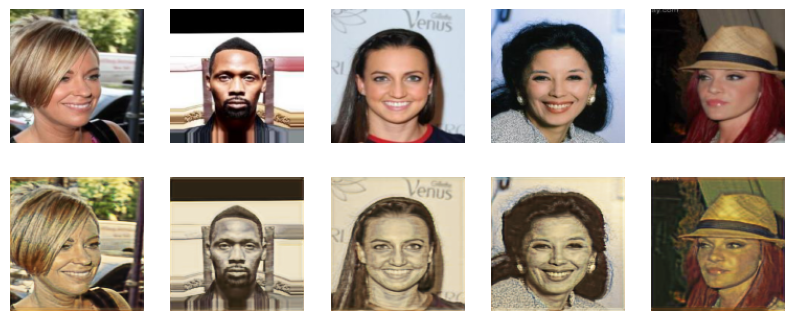

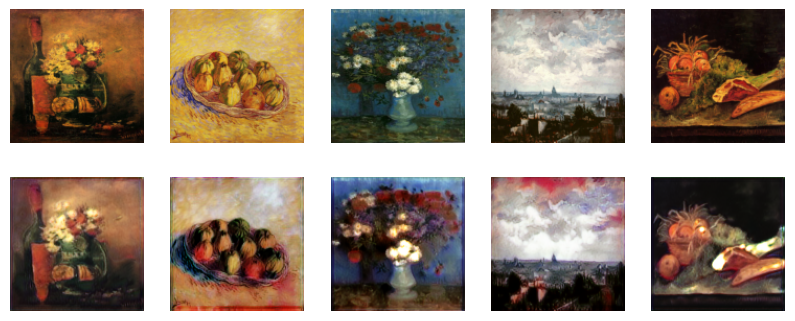

In [12]:
# Load some real and fake images for evaluation
def load_images_for_evaluation(dataset, num_images=100):
    images = []
    for i in range(min(num_images, len(dataset))):
        img = dataset[i]
        images.append(img)
    return images


# First load the 128x128 checkpoint
checkpoint_path = 'checkpoints/resolution_128/Checkpoint Res128 Epoch 5.pth'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

# Load model states
G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
G_BA.load_state_dict(checkpoint['G_BA_state_dict'])

# Set evaluation resolution
evaluation_resolution = 128

# Load evaluation images
real_images_A = load_images_for_evaluation(dataloaders_A[evaluation_resolution].dataset, num_images=100)
real_images_B = load_images_for_evaluation(dataloaders_B[evaluation_resolution].dataset, num_images=100)

fake_images_A = []
fake_images_B = []

# Generate fake images
G_AB.eval()
G_BA.eval()
with torch.no_grad():
    for img in real_images_A:
        img = img.unsqueeze(0).to(device)
        # Update step to match 128x128 resolution
        step = resolutions.index(128)
        fake_img = G_AB(img, step=step).cpu().squeeze(0)
        fake_images_B.append(fake_img)
    
    for img in real_images_B:
        img = img.unsqueeze(0).to(device)
        fake_img = G_BA(img, step=step).cpu().squeeze(0)
        fake_images_A.append(fake_img)

# Calculate metrics and visualize
fid_score = calculate_fid(real_images_A, fake_images_B)
print(f'FID Score for {evaluation_resolution}x{evaluation_resolution}: {fid_score}')

inception_score, inception_std = calculate_inception_score(fake_images_B)
print(f'Inception Score for 128x128: {inception_score} ± {inception_std}')

# Visualize some results
def visualize_results(real, fake, num_samples=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        # Real images
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(np.transpose(real[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.axis('off')
        
        # Fake images
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(np.transpose(fake[i].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# Example visualization
visualize_results(real_images_A, fake_images_B)
visualize_results(real_images_B, fake_images_A)